In [1]:
import numpy as np
from datetime import timedelta
import os, sys
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

notebook_path = os.getcwd()
print(notebook_path)
sys.path.append(os.path.join(notebook_path, '..', '..'))
from studies.flair import Flair

/Users/jan/git/nudgebg/egvinsulin/notebooks/understand-flair-dataset


# TDD

In [2]:
study_dataset_path = os.path.join(notebook_path, '..','..', 'data', 'raw', 'FLAIRPublicDataSet')
flair = Flair('Flair', study_dataset_path)
flair.load_data()
basal = flair.extract_basal_event_history()
bolus = flair.extract_bolus_event_history()

Now we calculate TDD, once based on the extracted basal and bolus information (calculated) and once on the reported TDD of the flair data (reported)

In [3]:
def calculate_tdd_basals(df):
    #add support points around midnight 
    supports = pd.date_range(df.datetime.min().date(), df.datetime.max().date()+pd.Timedelta(days=1), freq='D')
    missing_supports = supports[~supports.isin(df.datetime)]
    
    df = pd.concat([df, pd.DataFrame({'datetime': missing_supports})]).sort_values(by='datetime').reset_index(drop=True)
    df['basal_rate'] = df.basal_rate.ffill()
    #calculate TDDs, one day at a time
    TDDs  = []
    for (start,end) in zip(supports[:-1], supports[1:]):
        subFrame = df.loc[(df.datetime >= start) & (df.datetime <= end)]
        x = (subFrame.datetime.diff().dt.total_seconds()/3600).values[1:]
        y = subFrame['basal_rate'].values[:-1]
        tdd = np.nansum(x * y)
        TDDs.append(tdd)
    return pd.DataFrame({'date': supports[:-1].date, 'basal': TDDs})

from datetime import datetime
#test 1
test = pd.DataFrame({'datetime':[datetime(2019,1,1),datetime(2019,1,1,12)], 'basal_rate':[0,1.5]})
expected = pd.DataFrame({'date':[datetime(2019,1,1).date()], 'basal':[18.0]})
calculated_tdd = calculate_tdd_basals(test)
assert np.all(calculated_tdd['basal'].values == expected['basal'].values)

#test 2
test = pd.DataFrame({'datetime':[datetime(2019,1,1),datetime(2019,1,1,6),datetime(2019,1,1,12)], 'basal_rate':[0,1,2]})
expected = pd.DataFrame({'date':[datetime(2019,1,1).date()], 'basal':[30.0]})
calculated_tdd = calculate_tdd_basals(test)
assert np.all(calculated_tdd['basal'].values == expected['basal'].values)

#test 2
test = pd.DataFrame({'datetime':[datetime(2019,1,1,12)], 'basal_rate':[1]})
expected = pd.DataFrame({'date':[datetime(2019,1,1).date()], 'basal':[12.0]})
calculated_tdd = calculate_tdd_basals(test)
assert np.all(calculated_tdd['basal'].values == expected['basal'].values)


In [4]:
def extract_TDDs():
    tdds_flair = flair.df_pump.dropna(subset=['TDD'])[['PtID','DateTime','TDD']]
    tdds_flair['date'] = tdds_flair.DateTime.dt.date
    tdds_flair['datetime'] = tdds_flair.DateTime
    tdds_flair['PtID'] = tdds_flair.PtID.astype(str)
    tdds_flair = tdds_flair.rename(columns={'PtID':'patient_id','TDD':'tdd'})
    return tdds_flair

#get reported tdd 
tdd_reported = extract_TDDs().set_index(['patient_id','date'])
tdd_reported.name = 'reported'

#calculate basal tdd
tdd_basals = pd.DataFrame(basal.groupby(basal.patient_id).apply(calculate_tdd_basals))
tdd_basals = tdd_basals.reset_index().set_index(['patient_id','date']).drop(columns='level_1')

#calcualte bolus tdd
date = bolus.datetime.dt.date
date.name='date'
tdd_boluses = bolus.groupby(['patient_id',date]).agg({'bolus':'sum'})

#combine bolus and basal tdds
tdds_calculated = pd.merge(tdd_boluses ,tdd_basals, left_index=True, right_index=True, suffixes=['_bolus','_basal'])
tdds_calculated['tdd'] = tdds_calculated.bolus + tdds_calculated.basal

#combine dataframes and scatter plot
TDDs = pd.merge(tdds_calculated, tdd_reported, left_index=True, right_index=True, suffixes=['_calculated','_reported'])
display(TDDs)

bolus      basal  tdd_calculated            DateTime  \
patient_id date                                                               
1          2018-08-08  16.50  12.365611       28.865611 2018-08-08 23:59:59   
           2018-08-09  26.00  24.870528       50.870528 2018-08-09 23:59:59   
           2018-08-10  16.10  30.171111       46.271111 2018-08-10 23:59:59   
           2018-08-11  17.80  24.464417       42.264417 2018-08-11 23:59:59   
           2018-08-12  28.50  25.651111       54.151111 2018-08-12 23:59:59   
...                      ...        ...             ...                 ...   
99         2019-02-28  43.97  32.990611       76.960611 2019-02-28 23:59:59   
           2019-03-01  44.28  32.440722       76.720722 2019-03-01 23:59:59   
           2019-03-02  53.91  31.958111       85.868111 2019-03-02 23:59:59   
           2019-03-03  44.47  32.752222       77.222222 2019-03-03 23:59:59   
           2019-03-04  47.74  33.114667       80.854667 2019-03-04 23:59:59   

                       tdd_reported            datetime  
patient_id date                                          
1          2018-08-08        28.875 2018-08-08 23:59:59  
           2018-08-09        50.825 2018-08-09 23:59:59  
           2018-08-10        46.250 2018-08-10 23:59:59  
           2018-08-11        42.300 2018-08-11 23:59:59  
           2018-08-12        54.100 2018-08-12 23:59:59  
...                             ...                 ...  
99         2019-02-28        43.125 2019-02-28 23:59:59  
           2019-03-01        43.575 2019-03-01 23:59:59  
           2019-03-02        53.150 2019-03-02 23:59:59  
           2019-03-03        44.500 2019-03-03 23:59:59  
           2019-03-04        50.350 2019-03-04 23:59:59  

[25252 rows x 6 columns]

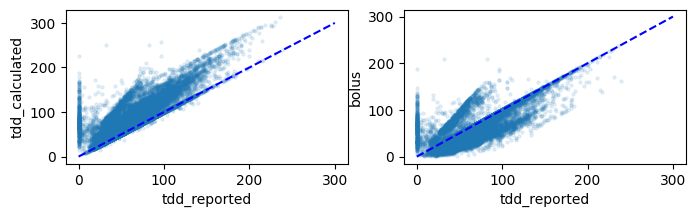

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
TDDs.plot.scatter(x='tdd_reported', y='tdd_calculated', marker='.', alpha=0.1, ax=axs[0])
axs[0].plot([0, 300], [0, 300], 'b--')
TDDs.plot.scatter(x='tdd_reported', y='bolus', marker='.', alpha=0.1, ax=axs[1])
axs[1].plot([0, 300], [0, 300], 'b--')

What we see is that the 
* calcualted tdds differ significantly from the extracted tdds 
* mostly calculated TDDs are too hight

There are multiple clusters:
 * Many instances where the extracted TDD is zero
 * Many instances where the calcualted is higher what appears to be a linear offset
* When looking at the boluses only, some TDDs are still too high.

Potential explanation for this: Potentiually the algorithm was switched and reported basal-rates were not actually delivered. Therefore, let's visualize reported basal rates by date.

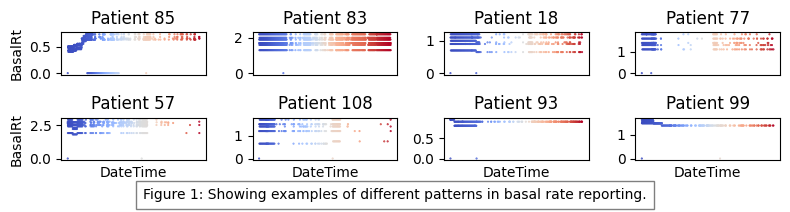

In [6]:
#patient_ids = [85,27,83,   18,77,104,  56,57,108,  53,93,99]
patient_ids = [85,83,   18,77,  57,108,  93,99]
#patient_ids = np.random.choice(np.unique(flair.df_pump.PtID.unique()),8, replace=False)
fig, axs = plt.subplots(2,4, figsize=(8, 2)); axs = axs.flatten()
for i, patient_id in enumerate(patient_ids):
    subFrame = flair.df_pump.loc[flair.df_pump.PtID == patient_id]#.dropna(subset=['BasalRt'])
    axs[i].scatter(subFrame['DateTime'], subFrame['BasalRt'], c=range(len(subFrame)), cmap='coolwarm', marker='.',s=1)
    axs[i].set_title(f'Patient {patient_id}')
    #hide x ticks
    axs[i].set_xticks([])
    if i>=4:
        axs[i].set_xlabel('DateTime')
    if i%4==0:
        axs[i].set_ylabel('BasalRt')

plt.tight_layout()
plt.figtext(0.5, -0.02, "Figure 1: Showing examples of different patterns in basal rate reporting.", ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
plt.show()


1. First row: basal rates regularly change start to end
2. Second Row: basal rates changebut in the middle they are not reported or very infrequently
3. Third Row: Basal rates are first reported regularly, then stop or very rarely
4. Forth Row: Basal rates remain constant 

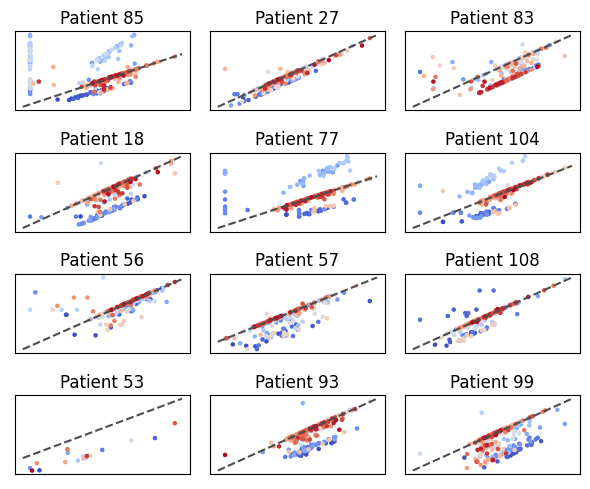

In [7]:
#scatter plot tdd_calcualted vs tdd_extracted for this patient
patient_ids = [85,27,83,   18,77,104,  56,57,108,  53,93,99]

fig, axs = plt.subplots(4, 3, figsize=(6, 5)); axs = axs.flatten()
for i, patient_id in enumerate(patient_ids):
    TDDs.loc[str(patient_id)].plot.scatter(x='tdd_reported', y='bolus', c=range(len(TDDs.loc[str(patient_id)])), cmap='coolwarm', marker='.', ax=axs[i])
    axs[i].set_title(f'Patient {patient_id}')
    #unity line
    axs[i].plot(axs[i].get_xlim(), axs[i].get_xlim(), ls="--", c=".3")
    #hide x and y ticks
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].set_xlabel(''); axs[i].set_ylabel('')
plt.tight_layout()
plt.show()

In order to understand what is really happening, we need to look at the study protocol and individuals. Let's start with patient 99 for which we know the bolus alsmost exactly matches TDD:


## Investigate Patient 99 more closely

We now investigate patient 99:

bolus                           43.97
basal                       32.990611
tdd_calculated              76.960611
DateTime          2019-02-28 23:59:59
tdd_reported                   43.125
datetime          2019-02-28 23:59:59
Name: 2019-02-28, dtype: object

Text(0.5, 0.98, 'Patient 99')

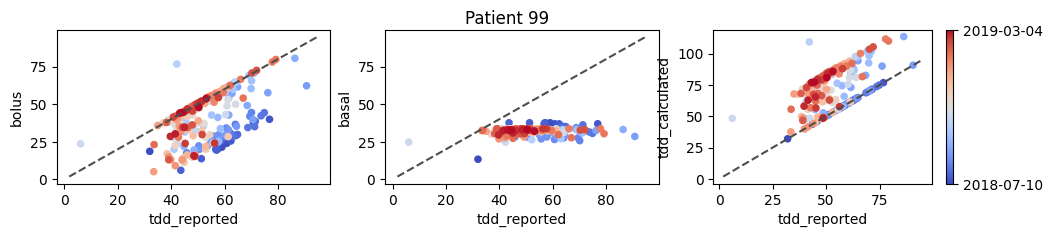

In [8]:
f, AX = plt.subplots(1,3, figsize=(12, 2))
display(TDDs.loc['99'].iloc[-5])
#scatter plot tdd_calcualted vs tdd_extracted for this patient
TDDs.loc['99'].sort_index().plot.scatter(x='tdd_reported', y='bolus', c=range(len(TDDs.loc['99'])), cmap='coolwarm', marker='o', ax = AX[0])
TDDs.loc['99'].sort_index().plot.scatter(x='tdd_reported', y='basal', c=range(len(TDDs.loc['99'])), cmap='coolwarm', marker='o', ax = AX[1])
TDDs.loc['99'].sort_index().plot.scatter(x='tdd_reported', y='tdd_calculated', c=range(len(TDDs.loc['99'])), cmap='coolwarm', marker='o', ax = AX[2])

#add unity line with limits to the limits of the current axis
AX[0].plot(AX[0].get_xlim(), AX[0].get_xlim(), ls="--", c=".3")
AX[1].plot(AX[1].get_xlim(), AX[1].get_xlim(), ls="--", c=".3")
AX[2].plot(AX[2].get_xlim(), AX[2].get_xlim(), ls="--", c=".3")
#add a heatmap of the colors that we used for scatter plotting
# Add a heatmap of the colors that we used for scatter plotting
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=len(TDDs.loc['99'])))
cbar = plt.colorbar(sm)
cbar.set_ticks([0, len(TDDs.loc['99'])])  # Set ticks to start and end
cbar.set_ticklabels([TDDs.loc['99'].index.min(), TDDs.loc['99'].index.max()])  # Set tick labels to start and end dates
#title patient id
f.suptitle('Patient 99')

In [9]:
from datetime import datetime
#patient 99 date 2019-02-28
date = datetime(2019,2,28).date()
patient = 99
print(f"TDD for patient {patient} is {TDDs.tdd_reported.loc[str(patient),date].values[0]}")

#get the raw data subframe for that day
df = flair.df_pump.loc[(flair.df_pump.PtID==patient) & (flair.df_pump.DateTime.dt.date == date)]
print(f"Bolus delivered sum is {df.BolusDeliv.sum()}")

subBasals = basal.loc[(basal.patient_id == str(patient)) & (basal.datetime.dt.date == date)]
print(f"There are {len(df.dropna(subset=['BasalRt']))} basal events in the original dataframe but {len(subBasals)} in the extracted basal dataframe")
display(subBasals)

TDD for patient 99 is 43.125
Bolus delivered sum is 43.97
There are 0 basal events in the original dataframe but 2 in the extracted basal dataframe


,patient_id,datetime,basal_rate
2520575,99,2019-02-28 05:49:32,0.0
2520574,99,2019-02-28 06:15:39,1.4


As we can see, for this day there are no basals! So we must have an error in the basal forward filling. 

The original dataframe has no data but the extracted does. We see that the index 2520574 is in fact a suspend event. We probably used this to forward propagate the basal rate of the previous day. We see that no basal rates were reported after the 27th and we forward filled this for the suspends. This might have been wrong. It looks like this is the end of the dataframe.

In [10]:
# show row 2520574
flair.df_pump.loc[2520574]

PtID                                     99
DataDtTm               2/28/2019 6:15:39 AM
NewDeviceDtTm                           NaN
BasalRt                                 NaN
BasalRtUnKnown                        False
TempBasalAmt                            NaN
TempBasalType                           NaN
TempBasalDur                            NaN
BolusType                               NaN
BolusSelected                           NaN
BolusDeliv                              NaN
ExtendBolusDuration                     NaN
PrimeVolumeDeliv                        NaN
Suspend                      NORMAL_PUMPING
Rewind                                  NaN
BolusSource                             NaN
TDD                                     NaN
DateTime                2019-02-28 06:15:39
Name: 2520574, dtype: object

## Zero TDDs
Let's start investigating a day where reported TDD is zero. 

In [11]:
#let's look at the first row (patient 14, date 2019-09-17)
tmp = flair.df_pump.loc[(flair.df_pump.PtID==14) & (flair.df_pump.DateTime.dt.date == datetime(2019,9,17).date())]
tmp.dropna(subset=['BolusDeliv','BasalRt'],how='all').sort_values('DateTime').head(10)[['PtID','DateTime','BolusDeliv','BolusSource','BasalRt']]

,PtID,DateTime,BolusDeliv,BolusSource,BasalRt
2422868,14,2019-09-17 00:00:00,NaN,NaN,1.55
2443131,14,2019-09-17 00:04:52,0.180,CLOSED_LOOP_MICRO_BOLUS,NaN
156388,14,2019-09-17 00:04:52,0.175,CL_MICRO_BOLUS,NaN
2443130,14,2019-09-17 00:09:44,0.050,CLOSED_LOOP_MICRO_BOLUS,NaN
156387,14,2019-09-17 00:09:44,0.050,CL_MICRO_BOLUS,NaN
156386,14,2019-09-17 00:14:42,0.050,CL_MICRO_BOLUS,NaN
2443129,14,2019-09-17 00:14:42,0.050,CLOSED_LOOP_MICRO_BOLUS,NaN
156385,14,2019-09-17 00:19:52,0.275,CL_MICRO_BOLUS,NaN
2443128,14,2019-09-17 00:19:52,0.280,CLOSED_LOOP_MICRO_BOLUS,NaN
156384,14,2019-09-17 00:24:50,0.275,CL_MICRO_BOLUS,NaN


As a surprise finding, we see that the CLOSED_LOOP+MICRO_BOLUS and CL_MICRO_BOLUS are duplicated for this patient.  Let's how often we have duplicates.

## Bolus Duplicates

In [ ]:
temp = flair.df_pump.dropna(subset=['BolusDeliv'])
duplicates = temp.duplicated(subset=['PtID', 'DateTime', 'BolusDeliv'], keep='first')
temp[duplicates]['BolusSource'].value_counts()

CL_MICRO_BOLUS                              36692
CLOSED_LOOP_MICRO_BOLUS                     36287
CL_BG_CORRECTION_N_FOOD_BOLUS                1658
CLOSED_LOOP_BG_CORRECTION_AND_FOOD_BOLUS     1646
CLOSED_LOOP_FOOD_BOLUS                        693
CL_FOOD_BOLUS                                 638
CLOSED_LOOP_BG_CORRECTION                     174
CL_BG_CORRECTION                              166
BOLUS_WIZARD                                   67
MANUAL                                          7
Name: BolusSource, dtype: int64

Let's continue checking how often we have duplicates for micro boluses

In [32]:
temp = flair.df_pump.dropna(subset=['BolusDeliv'])
temp = temp[temp.BolusSource.isin(['CL_MICRO_BOLUS', 'CLOSED_LOOP_MICRO_BOLUS'])]

duplicates = temp.duplicated(subset=['PtID','DateTime', 'BolusDeliv'], keep='first')
print(f"Number of duplicated micro boluses rows {duplicates.sum()} in percent these are {100*duplicates.sum()/len(temp):.1f}% of all micro boluses")

#show the first 4 duplicated rows
duplicates = temp.duplicated(subset=['PtID', 'DateTime', 'BolusDeliv'], keep=False)#this makes sure we keep all duplicates for displaying
temp[duplicates].dropna(subset=['BolusDeliv'],how='all').sort_values('DateTime').head(2).dropna(axis=1).drop(['DataDtTm'], axis=1)

Number of duplicated micro boluses rows 72979 in percent these are 2.3% of all micro boluses


,PtID,BasalRtUnKnown,BolusType,BolusSelected,BolusDeliv,BolusSource,DateTime
1223509,20,False,Normal,0.1,0.1,CLOSED_LOOP_MICRO_BOLUS,2018-08-23 18:15:44
101098,20,False,Normal,0.1,0.1,CL_MICRO_BOLUS,2018-08-23 18:15:44


In [13]:
temp = flair.df_pump.dropna(subset=['BolusDeliv'])
duplicates = temp.duplicated(subset=['PtID', 'DateTime', 'BolusDeliv'], keep='first') #keep only first duplciate row
print(f"Overall, we have {duplicates.sum()} duplicated bolus rows which makes {duplicates.sum()/len(temp)*100:.2f}% of all boluses")
#show the first 4 duplicated rows
duplicates = temp.duplicated(subset=['PtID', 'DateTime', 'BolusDeliv'], keep=False)#this makes sure we keep all duplicates for displaying
temp[duplicates].dropna(subset=['BolusDeliv'],how='all').sort_values('DateTime').head(2).dropna(axis=1,how='all').drop(['DataDtTm','BasalRtUnKnown'],axis=1)

Overall, we have 78088 duplicated bolus rows which makes 2.20% of all boluses


,PtID,BolusType,BolusSelected,BolusDeliv,ExtendBolusDuration,BolusSource,DateTime
104176,20,Dual (square part),2.3,2.3,0:30:00,NaN,2018-07-11 19:18:00
1223945,20,Dual (square part),2.3,2.3,0:30:00,BOLUS_WIZARD,2018-07-11 19:18:00


Let's see how many duplicates we have per bolus source 

### TDD after removing duplicated Boluses

In [15]:
bolus_wo_dups = bolus[~bolus.duplicated(subset=['patient_id','datetime', 'bolus'], keep='first')]

#calcualte bolus tdd
date = bolus_wo_dups.datetime.dt.date
date.name='date'
tdd_boluses_wo_dups = bolus_wo_dups.groupby(['patient_id',date]).agg({'bolus':'sum'})
TDDs = TDDs.join(tdd_boluses_wo_dups, rsuffix='_wo_dups')

Text(0.5, -0.02, 'Figure 2:TDDs calculated from boluses after removing duplicates improves TDD (one cluster disappears).')

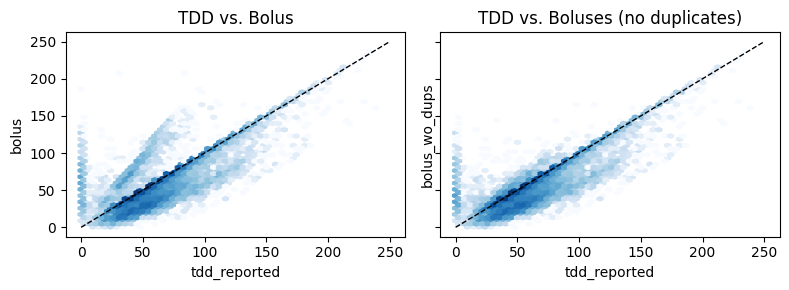

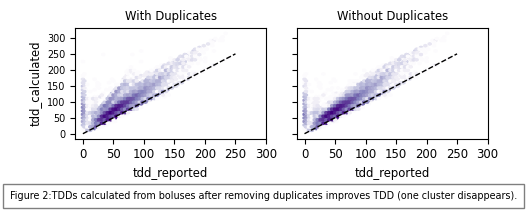

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

# Hexbin plot for TDD vs. Bolus with logarithmic color scale
hb1 = axs[0].hexbin(TDDs.tdd_reported, TDDs.bolus, gridsize=50, cmap='Blues', mincnt=1, norm=colors.LogNorm())
axs[0].set_xlabel('tdd_reported')
axs[0].set_ylabel('bolus')
axs[0].set_title('TDD vs. Bolus')
#cb1 = fig.colorbar(hb1, ax=axs[0])
#cb1.set_label('log(count)')
axs[0].plot([0, 250], [0, 250], '--',color='black',linewidth=1)

# Hexbin plot for TDD vs. Boluses (no duplicates) with logarithmic color scale
hb2 = axs[1].hexbin(TDDs.tdd_reported, TDDs.bolus_wo_dups, gridsize=50, cmap='Blues', mincnt=1, norm=colors.LogNorm())
axs[1].set_xlabel('tdd_reported')
axs[1].set_ylabel('bolus_wo_dups')
axs[1].set_title('TDD vs. Boluses (no duplicates)')
axs[1].plot([0, 250], [0, 250], '--',color='black',linewidth=1)
plt.tight_layout()

# Repeat for the second set of plots with logarithmic color scale
fig, axs = plt.subplots(1, 2, figsize=(5, 2), sharex=True, sharey=True)

# Hexbin plot for TDD vs TDD with logarithmic color scale
hb3 = axs[0].hexbin(TDDs.tdd_reported, TDDs.bolus+TDDs.basal, gridsize=50, cmap='Purples', mincnt=1, norm=colors.LogNorm())
axs[0].set_xlabel('tdd_reported',fontsize='small')
axs[0].set_ylabel('tdd_calculated',fontsize='small')
axs[0].set_title('With Duplicates',fontsize='small')
axs[0].plot([0, 250], [0, 250], '--',color='black',linewidth=1)
axs[0].set_xticks(range(0, 301, 50))
axs[0].tick_params(axis='x', labelsize='small')
axs[0].set_yticks(range(0, 301, 50))
axs[0].tick_params(axis='y', labelsize='x-small')

# Hexbin plot for TDD vs. TDD (no duplicates) with logarithmic color scale
hb4 = axs[1].hexbin(TDDs.tdd_reported, TDDs.bolus_wo_dups+TDDs.basal, gridsize=50, cmap='Purples', mincnt=1, norm=colors.LogNorm())
axs[1].set_xlabel('tdd_reported',fontsize='small')
#axs[1].set_ylabel('tdd_calculated_wo_dups')
axs[1].set_title('Without Duplicates',fontsize='small')
axs[1].plot([0, 250], [0, 250], '--',color='black',linewidth=1)
axs[1].set_xticks(range(0, 301, 50))
axs[1].tick_params(axis='x', labelsize='small')
plt.tight_layout()
plt.figtext(0.5, -0.02, "Figure 2:TDDs calculated from boluses after removing duplicates improves TDD (one cluster disappears).", ha="center", fontsize='x-small', bbox={"facecolor":"white", "alpha":0.5, "pad":5})

## Reported TDD = Zero 
Continue with days where reported TDD is zero. What is going on there?

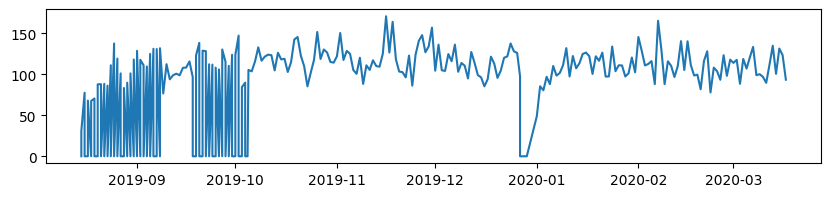

In [17]:
temp = flair.df_pump.loc[(flair.df_pump.PtID == 14)].dropna(subset=['TDD'])
plt.figure(figsize=(10, 2))
plt.plot(temp.DateTime, temp.TDD);

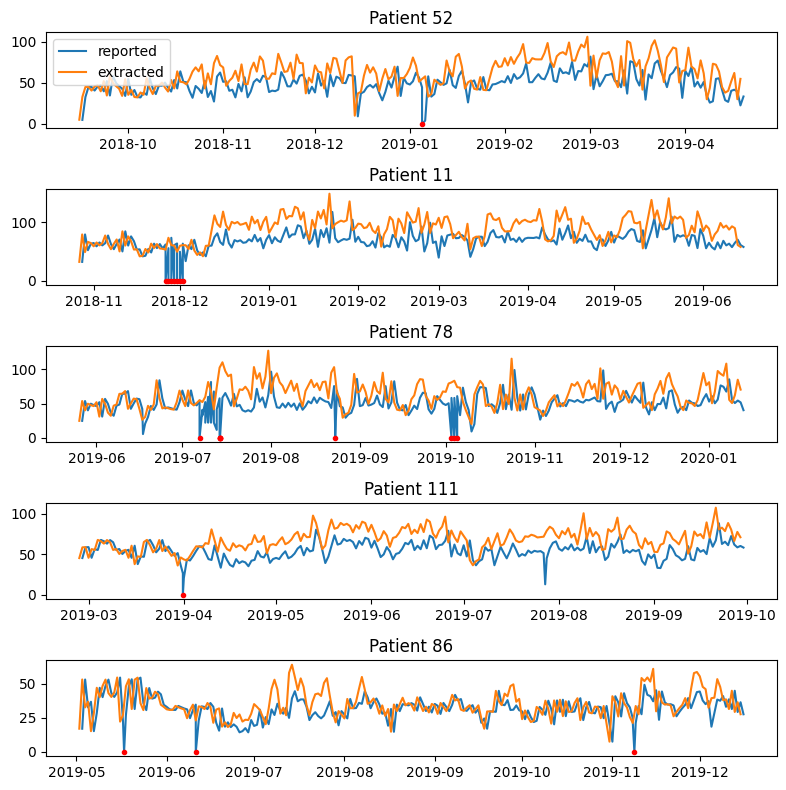

In [18]:
#get affected patients
tdd_zero = TDDs.loc[TDDs.tdd_reported == 0]
patients_with_tdd_zero = tdd_zero.index.get_level_values('patient_id').unique().astype(int)

# Select all patients with TDD zero
fig, axs = plt.subplots(5, 1, figsize=(8, 8))

for i, patient in enumerate(np.random.choice(patients_with_tdd_zero, 5)):
    temp = flair.df_pump.loc[(flair.df_pump.PtID == patient)].dropna(subset=['TDD'])
    bZero = temp.TDD == 0
    axs[i].plot(temp.DateTime, temp.TDD, label='reported')
    axs[i].plot(temp.DateTime[bZero], temp.TDD[bZero], 'r.')
    
    temp2 = TDDs.loc[str(patient)].reset_index()
    axs[i].plot(temp2.date, temp2.bolus_wo_dups + temp2.basal, label='extracted')
    axs[i].set_title(f"Patient {patient}")

axs[0].legend()
plt.tight_layout()
plt.show()


### Multiple TDDs?
Let's check if tdds are reported several times

In [19]:
# let's check if there are days where tdd is reported multiple times
display(TDDs.groupby(['patient_id','date']).tdd_reported.count().value_counts())

# let's check if there are days where tdd is reported multiple times
tdd_groups = TDDs.groupby(['patient_id','date'])
tdd_group_counts = tdd_groups.tdd_reported.count()
tdd_group_counts_ge2 = tdd_group_counts[tdd_group_counts > 2]
display(tdd_group_counts_ge2.head())


1    23047
2      925
3       91
4       13
5        6
Name: tdd_reported, dtype: int64

patient_id  date      
104         2019-06-10    5
            2019-06-21    3
111         2019-03-31    3
115         2019-04-14    3
117         2019-04-03    5
Name: tdd_reported, dtype: int64

In [20]:
#let's look at patient 104 on 2019-06-10 for which several TDDs are reported
x=flair.df_pump.loc[(flair.df_pump.PtID == 104) & (flair.df_pump.DateTime.dt.date == datetime(2019,6,10).date())].dropna(subset=['TDD'])
display(x.dropna(axis=1, how='all'))

,PtID,DataDtTm,BasalRtUnKnown,TDD,DateTime
972850,104,6/10/2019 6:37:00 PM,False,12.975,2019-06-10 18:37:00
4303707,104,6/10/2019 6:37:00 PM,False,12.970,2019-06-10 18:37:00
972841,104,6/10/2019 6:38:30 PM,False,0.000,2019-06-10 18:38:30
4303676,104,6/10/2019 11:59:59 PM,False,10.520,2019-06-10 23:59:59
972816,104,6/10/2019 11:59:59 PM,False,10.525,2019-06-10 23:59:59


We see that 
1. the tdds are unequal
2. a zero tdd in between
2. the last TDD is not the largest

### Describe TDD duplicates

In [124]:
print(f"There are {(tdd_reported.tdd==0).sum()} zero TDDs in the dataset")
print(f"There are {tdd_reported.DateTime.apply(lambda x: x.hour <23).sum()} TDDs reported before 23:00")

#get number of patients with multiple tdds per day
print(f"There are {tdd_reported.groupby(['patient_id','date']).size().gt(1).sum()} days with multiple TDDs reported")
multiple_tdds = TDDs.groupby(['patient_id','date']).filter(lambda x: len(x) > 1)
multiple_tdds_grps = multiple_tdds.groupby(['patient_id','date'])
last_zero = multiple_tdds_grps.filter(lambda x: x.tdd_reported[x.datetime.argmax()]==0)
print(f"There are {last_zero.groupby(['patient_id','date']).ngroups} days with multiple TDDs per day where the last TDD is zero")


There are 399 zero TDDs in the dataset
There are 286 TDDs reported before 23:00
There are 1040 days with multiple TDDs reported
There are 139 days with multiple TDDs per day where the last TDD is zero


This plot shows how for the days where we have multiple TDDs, tdds change over time. 
While many go up, others also go down. 

Text(0.5, 1.0, 'TDDs reported on same day')

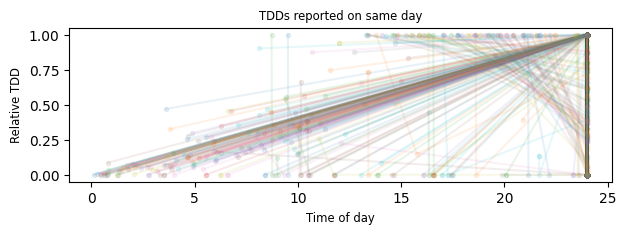

In [37]:
plt.figure(figsize=(7,2))
ax=plt.gca()
for name, grp in multiple_tdds_grps:
    grp = grp.sort_values(by='DateTime')
    rel_time = grp.DateTime.apply(lambda x: (x - pd.to_datetime(x.date())).total_seconds()/(3600))
    ax.plot(rel_time, grp.tdd/grp.tdd.max(), '.-',alpha=0.1)
    ax.set_xlabel('Time of day',fontsize='small')
    ax.set_ylabel('Relative TDD',fontsize='small')
    #ax.set_xticklabels(range(0,24,2),fontsize='small')
    
plt.title('TDDs reported on same day',fontsize='small')

The question is now, how do we deal with this: 
1. Taking the maximum reported TDD (this will not always yield the latest reported)
2. Taking the last reported TDD (This will not always report the maximum value, sometimes even 0)
3. Dropping zero TDDs (This will for some days drop tdd altogether)

In [167]:
#example keeping the latest TDD
latest  = TDDs.groupby(['patient_id','date']).apply(lambda x: x.iloc[x.DateTime.argmax()])
print(f"For the days with multiple TDDs, after keeping only the last TDD:...")
print(f"there are {(latest.tdd_reported==0).sum()} zero TDDs in the dataset")
print(f"there are {latest.datetime.apply(lambda x: x.hour <23).sum()} TDDs before 23:00")
print(f"there are {latest.groupby(['patient_id','date']).size().gt(1).sum()} patients with multiple TDDs per day")

#join for later use
TDDs = TDDs.join(latest['tdd_reported'],rsuffix='_latest')

For the days with multiple TDDs, after keeping only the last TDD:...
there are 141 zero TDDs in the dataset
there are 12 TDDs before 23:00
there are 0 patients with multiple TDDs per day


In [168]:
max_tdd  = TDDs.groupby(['patient_id','date']).apply(lambda x: x.iloc[x.tdd_reported.argmax()])
print(f"After keeping only the max TDD")
print(f"there are {(max_tdd.tdd_reported==0).sum()} zero TDDs in the dataset")
print(f"there are {max_tdd.datetime.apply(lambda x: x.hour <23).sum()} TDDs before 23:00")
print(f"there are {max_tdd.groupby(['patient_id','date']).size().gt(1).sum()} patients with multiple TDDs per day")

#join to TDDs
TDDs = TDDs.join(max_tdd['tdd_reported'],rsuffix='_max')

After keeping only the max TDD
there are 2 zero TDDs in the dataset
there are 68 TDDs before 23:00
there are 0 patients with multiple TDDs per day


In [ ]:
max_tdd  = TDDs.groupby(['patient_id','date']).agg(lambda x: x.iloc[x.tdd_reported.argmax()])
print(f"After keeping only the max TDD")
print(f"there are {(max_tdd.tdd_reported==0).sum()} zero TDDs in the dataset")
print(f"there are {max_tdd.datetime.apply(lambda x: x.hour <23).sum()} TDDs before 23:00")
print(f"there are {max_tdd.groupby(['patient_id','date']).size().gt(1).sum()} patients with multiple TDDs per day")

#join to TDDs
TDDs = TDDs.join(max_tdd['tdd_reported'],rsuffix='_max')

In [173]:
summed = TDDs.groupby(['patient_id','date']).agg({'tdd_reported':'sum'})
#join to TDDs
TDDs = TDDs.join(summed,rsuffix='_sum')

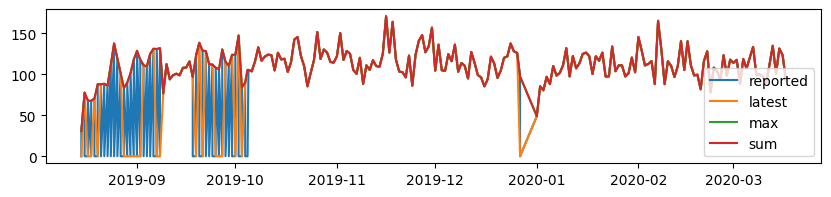

In [174]:
plt.figure(figsize=(10, 2))
plt.plot(TDDs.loc['14'].datetime, TDDs.loc['14'].tdd_reported, label='reported')
plt.plot(TDDs.loc['14'].datetime, TDDs.loc['14'].tdd_reported_latest, label='latest')
plt.plot(TDDs.loc['14'].datetime, TDDs.loc['14'].tdd_reported_max, label='max')
plt.plot(TDDs.loc['14'].datetime, TDDs.loc['14'].tdd_reported_sum, label='sum')
plt.legend()

As we can see there are some days where only 0 TDDs are reported

### Sum of TDDs
As an alternative, summing up TDDs by day could be a better alternative. As we can see for this patient, the sum of TDDs appears more natural. 

In [104]:
TDDs_summed = TDDs.groupby(['patient_id','date']).agg({'basal': 'first', 'bolus_wo_dups': 'first','tdd_reported':'sum', 'datetime':'max'})

basal  bolus_wo_dups  tdd_reported  \
patient_id date                                                 
1          2018-08-08  12.365611          16.50        28.875   
           2018-08-09  24.870528          26.00        50.825   
           2018-08-10  30.171111          16.10        46.250   
           2018-08-11  24.464417          17.80        42.300   
           2018-08-12  25.651111          28.50        54.100   
...                          ...            ...           ...   
99         2019-02-28  32.990611          43.97        43.125   
           2019-03-01  32.440722          44.28        43.575   
           2019-03-02  31.958111          53.91        53.150   
           2019-03-03  32.752222          44.47        44.500   
           2019-03-04  33.114667          47.74        50.350   

                                 datetime  
patient_id date                            
1          2018-08-08 2018-08-08 23:59:59  
           2018-08-09 2018-08-09 23:59:59  
           2018-08-10 2018-08-10 23:59:59  
           2018-08-11 2018-08-11 23:59:59  
           2018-08-12 2018-08-12 23:59:59  
...                                   ...  
99         2019-02-28 2019-02-28 23:59:59  
           2019-03-01 2019-03-01 23:59:59  
           2019-03-02 2019-03-02 23:59:59  
           2019-03-03 2019-03-03 23:59:59  
           2019-03-04 2019-03-04 23:59:59  

[24082 rows x 4 columns]

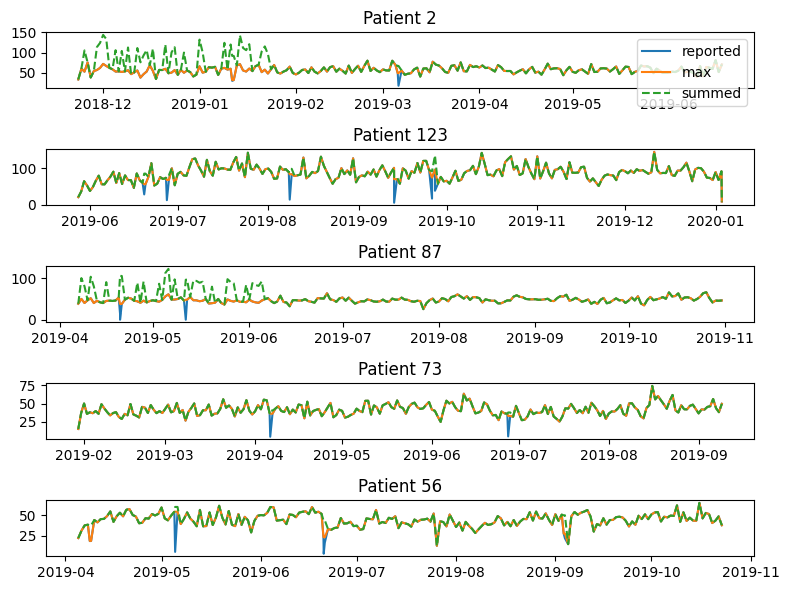

In [180]:
#get affected patients
duplicated_tdds = TDDs.groupby(['patient_id','date']).filter(lambda x: len(x) > 1)
patients_with_duplicated_tdds = duplicated_tdds.index.get_level_values('patient_id').unique().astype(int)

fig, axs = plt.subplots(5, 1, figsize=(8, 6))
for i, patient in enumerate(np.random.choice(patients_with_duplicated_tdds, 5)):
    #reported
    #temp = flair.df_pump.loc[(flair.df_pump.PtID == patient)].dropna(subset=['TDD'])
    temp = TDDs.loc[str(patient)]
    axs[i].plot(temp.datetime, temp.tdd_reported, label='reported')
    axs[i].plot(temp.datetime, temp.tdd_reported_max, label='max')
    axs[i].plot(temp.datetime, temp.tdd_reported_sum, '--',label='summed')

    axs[i].set_title(f"Patient {patient}")

axs[0].legend()
plt.tight_layout()
plt.show()


It appears that taking the 

Now, we show how the sum of TDDs would compare against the calculated TDD

(array([  8.,  75., 165., 342., 645., 409., 228., 239.,  77.,  17.]),
 array([-70.44402778, -53.93410972, -37.42419167, -20.91427361,
         -4.40435556,  12.1055625 ,  28.61548056,  45.12539861,
         61.63531667,  78.14523472,  94.65515278]),
 <BarContainer object of 10 artists>)

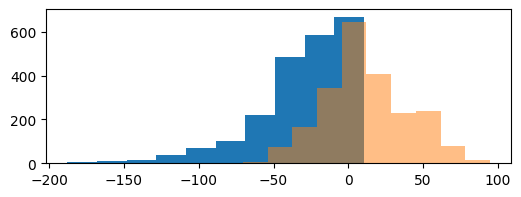

In [182]:
plt.figure(figsize=(6,2))
duplicated_tdds = TDDs.groupby(['patient_id','date']).filter(lambda x: len(x) > 1).reset_index()
plt.hist(duplicated_tdds.tdd_reported-(duplicated_tdds.basal+duplicated_tdds.bolus_wo_dups))
plt.hist(duplicated_tdds.tdd_reported_sum-(duplicated_tdds.basal+duplicated_tdds.bolus_wo_dups),alpha=0.5)

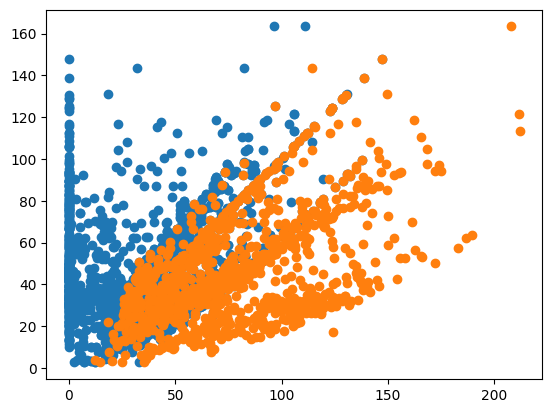

In [89]:
plt.scatter(duplicated_tdds.tdd_reported,duplicated_tdds.bolus_wo_dups)
plt.scatter(summed_tdd.tdd_reported,summed_tdd.bolus_wo_dups)

Here, we see that the reported are always lower than the calculated but if we take the sum the distribution becomes centered around zero. This is a good indication that we should take the sum.

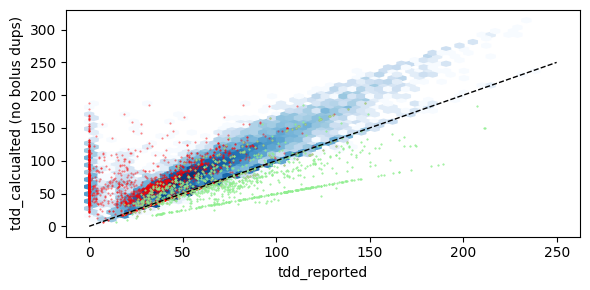

In [94]:
# Hexbin plot for TDD vs. Boluses (no duplicates) with logarithmic color scale
ax = plt.figure(figsize=(6,3)).gca()
hb2 = ax.hexbin(TDDs.tdd_reported, TDDs.bolus_wo_dups+TDDs.basal, gridsize=50, cmap='Blues', mincnt=1, norm=colors.LogNorm())
ax.set_xlabel('tdd_reported')
ax.set_ylabel('tdd_calcualted (no bolus dups)')
ax.plot([0, 250], [0, 250], '--',color='black',linewidth=1)
plt.tight_layout()


multiple_tdds = tdd_reported.groupby(['patient_id','date']).filter(lambda x: len(x) > 1)
multiple_tdds_grps = multiple_tdds.groupby(['patient_id','date'])
last_zero = multiple_tdds_grps.filter(lambda x: x.tdd[x.DateTime.argmax()]==0)

#overlay all tdds of days with multiple tdds
ax.scatter(duplicated_tdds.tdd_reported, duplicated_tdds.basal+duplicated_tdds.bolus_wo_dups, color='red', marker='.', s =1, alpha=0.5)

#overlay what happens if we sum up
ax.scatter(summed_tdd.tdd_reported, summed_tdd.basal+summed_tdd.bolus_wo_dups, color='lightgreen', marker='.', s =1)

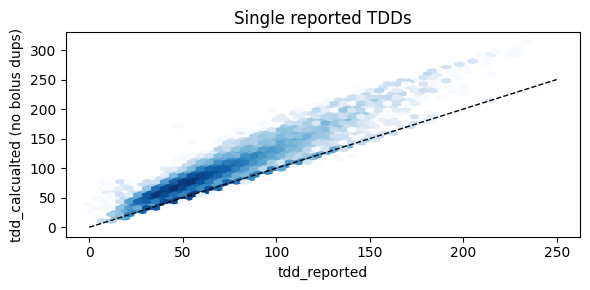

In [96]:
# Hexbin plot for TDD vs. Boluses (no duplicates) with logarithmic color scale
single_tdds = TDDs.groupby(['patient_id','date']).filter(lambda x: len(x) == 1)
ax = plt.figure(figsize=(6,3)).gca()
hb2 = ax.hexbin(single_tdds.tdd_reported, single_tdds.bolus_wo_dups+single_tdds.basal, gridsize=50, cmap='Blues', mincnt=1, norm=colors.LogNorm())
ax.set_xlabel('tdd_reported')
ax.set_ylabel('tdd_calcualted (no bolus dups)')
ax.set_title('Single reported TDDs')
ax.plot([0, 250], [0, 250], '--',color='black',linewidth=1)
plt.tight_layout()



Taking the sum removes the zero TDDs but it also now, many calcualted tdds are too low.

## Algorithm Impact on reported TDDs?

first we merge with patient roster to get the control group (remember this is cross over study)

In [26]:
df_patient = pd.read_csv(os.path.join(study_dataset_path,'Data Tables', 'PtRoster.txt'),sep='|')
merged = flair.df_pump.merge(df_patient[['PtID','TrtGroup']],on='PtID')
display(merged.TrtGroup.value_counts())

#get the time and day since study start
merged['time_sinde_study_start'] = merged.groupby(['PtID']).DateTime.apply(lambda x: x-x.min())
merged['days_since_study_start'] = merged['time_sinde_study_start'].transform(lambda x: x.days)

670G    2567427
AHCL    2531833
Name: TrtGroup, dtype: int64

In [27]:
#reported TDDs by day
temp = merged.groupby(['TrtGroup','PtID','days_since_study_start']).agg(reported_tdd_count = ('TDD', 'count'))
display(temp.groupby(['TrtGroup']).agg({'reported_tdd_count':'sum'}))

#number of days with more than one TDD
temp = merged.groupby(['TrtGroup','PtID','days_since_study_start']).agg(reported_tdd_count = ('TDD', 'count'))
display(temp.groupby(['TrtGroup']).agg({'reported_tdd_count':lambda x: x.gt(1).sum()}))

,reported_tdd_count
TrtGroup,
670G,12462
AHCL,12819


,reported_tdd_count
TrtGroup,
670G,337
AHCL,690


Interestingly, AHCL group has twice as many days with more than one reported TDD

In [28]:
#zero TDDS
merged.groupby(['TrtGroup']).agg({'TDD': lambda x: (x==0).sum()})

,TDD
TrtGroup,
670G,75
AHCL,322


When patients start on AHCL, then we see many more zero TDDs being reported. This is surprising given that all patients use both algorithms.

check if the auto_boluses differ between treatment groups 

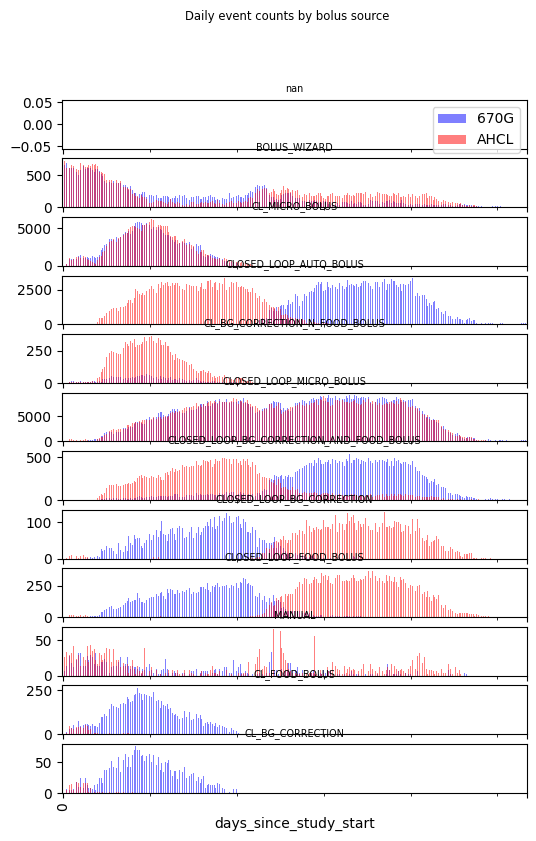

In [29]:

#draw bolus source types
fig, axs = plt.subplots(len(merged.BolusSource.unique()), 1, figsize=(6, 9),sharex=True, sharey=False)
for i, bolus_source in enumerate(merged.BolusSource.unique()):
    ax = axs[i]
    temp = merged.groupby(['TrtGroup', 'days_since_study_start']).agg(micro_bolus_count=('BolusSource', lambda x: (x == bolus_source).sum())).reset_index(level=1)
    temp.loc['670G'].reset_index().plot.bar(x='days_since_study_start', y='micro_bolus_count', ax=ax, label='670G', color='blue', alpha=0.5)
    temp.loc['AHCL'].reset_index().plot.bar(x='days_since_study_start', y='micro_bolus_count', ax=ax, color='red', label='AHCL', alpha=0.5)
    ax.set_title(bolus_source,fontsize='x-small')
    ax.set_xticks([temp.days_since_study_start.min(), temp.days_since_study_start.max()])
    if i == 0:
        ax.legend()
    else:
        ax.get_legend().remove()
plt.suptitle('Daily event counts by bolus source',fontsize='small')
plt.show()

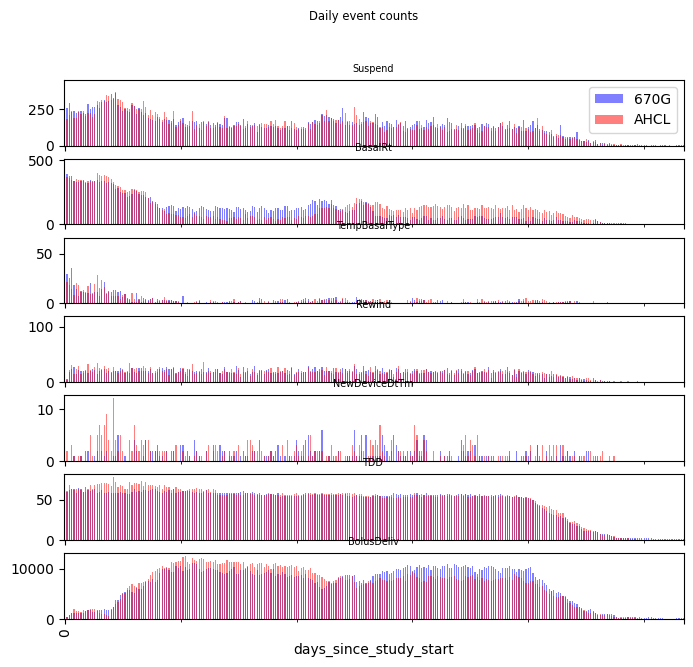

In [30]:
#draw bolus source types
events = ['Suspend','BasalRt','TempBasalType','Rewind','NewDeviceDtTm','TDD','BolusDeliv']
fig, axs = plt.subplots(len(events), 1, figsize=(8, 1*len(events)),sharex=True, sharey=False)
for i, column in enumerate(events):
    ax = axs[i]
    temp = merged.groupby(['TrtGroup', 'days_since_study_start']).agg({column:'count'}).reset_index(level=1)
    temp.loc['670G'].reset_index().plot.bar(x='days_since_study_start', y=column, ax=ax, label='670G', color='blue', alpha=0.5)
    temp.loc['AHCL'].reset_index().plot.bar(x='days_since_study_start', y=column, ax=ax, color='red', label='AHCL', alpha=0.5)
    ax.set_title(column, fontsize='x-small')
    ax.set_xticks([temp.days_since_study_start.min(), temp.days_since_study_start.max()])
    if i == 0:
        ax.legend()
    else:
        ax.get_legend().remove()
plt.suptitle('Daily event counts',fontsize='small')
plt.show()

Findings
1) Basl Rates are less often in the AHCL algorithm 
2) What we see is that the Auto Boluses source is not reported in the 670G treatment arm. (Remeber, this is crossover). 
3) CL_MICRO_BOLUSES are only reported at the beginning (maybe label change to CLOSED_LOOP_MICRO_BOLUS?)

In [31]:
filtered.groupby(['patient_id','date']).tdd.count().value_counts()

NameError: name 'filtered' is not defined

CLOSED_LOOP_MICRO_BOLUS                     2628112
CL_MICRO_BOLUS                               542076
CLOSED_LOOP_AUTO_BOLUS                       490478
BOLUS_WIZARD                                  96003
CLOSED_LOOP_BG_CORRECTION_AND_FOOD_BOLUS      84708
CLOSED_LOOP_FOOD_BOLUS                        46554
CL_BG_CORRECTION_N_FOOD_BOLUS                 17901
CLOSED_LOOP_BG_CORRECTION                     15482
CL_FOOD_BOLUS                                 11734
MANUAL                                         4240
CL_BG_CORRECTION                               3158
Name: BolusSource, dtype: int64